In [2]:
import torch 


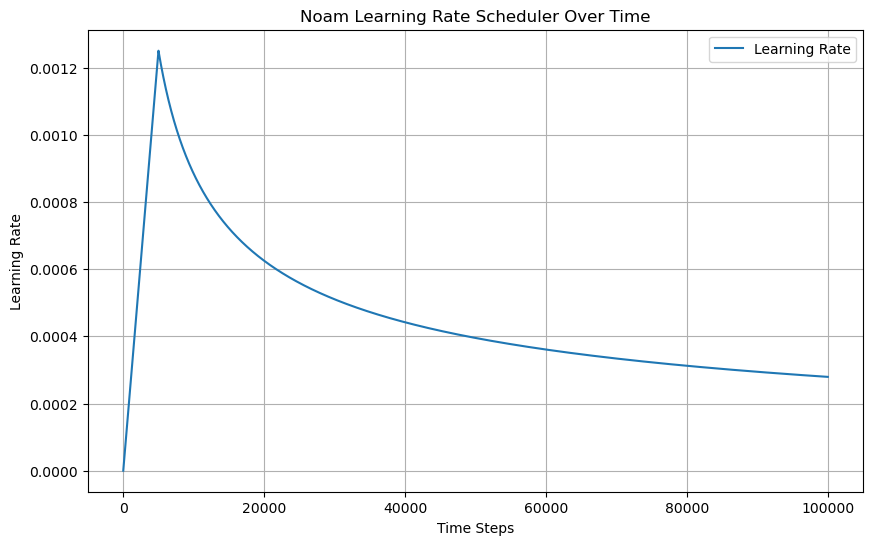

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the Noam learning rate scheduler
warmup_steps = 5000  # Example value for warmup steps
initial_lr = 0.1  # Example starting learning rate
d_model = 256
# Define Noam learning rate scheduler function
def noam_scheduler(step, warmup_steps):
    return  d_model ** -0.5 * min((step + 1) ** -0.5, (step + 1) * warmup_steps ** -1.5)

# Generate time steps
time_steps = np.arange(0, 100000, 1)

# Calculate the learning rate at each time step
learning_rates = [noam_scheduler(step, warmup_steps) for step in time_steps]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(time_steps, learning_rates, label='Learning Rate')
plt.xlabel('Time Steps')
plt.ylabel('Learning Rate')
plt.title('Noam Learning Rate Scheduler Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
! pip install filterpy

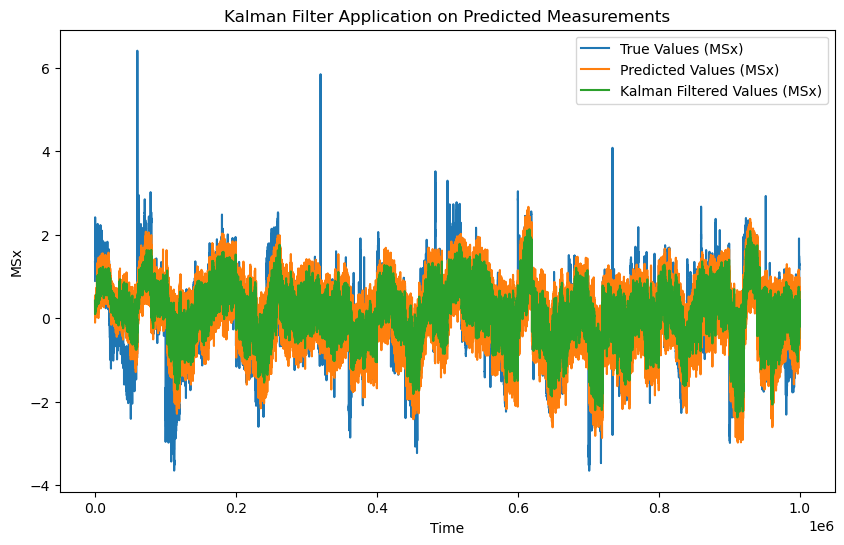

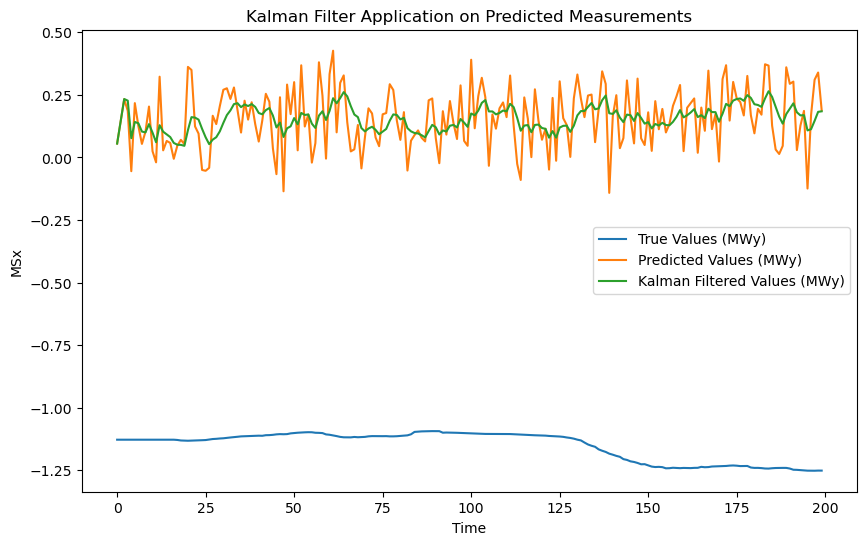

In [12]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# Assuming 'predicted_measurements' is the numpy array with your predicted measurements
predicted_measurements = pd.read_csv("all_training_outputs.csv").to_numpy()
true_measurements = pd.read_csv("all_training_targets.csv").to_numpy()
# and 'true_measurements' is the numpy array with the true measurements for testing

# Estimate measurement noise covariance R
residuals = predicted_measurements - true_measurements
measurement_noise_cov = np.var(residuals, axis=0)

# Estimate process noise covariance Q
state_transitions = np.diff(true_measurements, axis=0)
process_noise_cov = np.var(state_transitions, axis=0)

# Initialize Kalman Filter for each measurement
kf_list = []
for i in range(predicted_measurements.shape[1]):  # Number of measurements
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([[0.], [0.]])  # Initial state (location and velocity)
    kf.F = np.array([[1., 1.], [0., 1.]])  # State transition matrix
    kf.H = np.array([[1., 0.]])  # Measurement function
    kf.P *= 1000.  # Initial covariance matrix
    kf.R = measurement_noise_cov[i]  # Measurement noise covariance
    kf.Q = process_noise_cov[i] * np.eye(2)  # Process noise covariance
    kf_list.append(kf)

# Apply Kalman Filter to each predicted measurement
filtered_measurements_kf = np.zeros_like(predicted_measurements)
for i in range(predicted_measurements.shape[1]):
    kf = kf_list[i]
    for j in range(predicted_measurements.shape[0]):
        kf.predict()  # Prediction step
        kf.update(predicted_measurements[j, i])  # Update step
        filtered_measurements_kf[j, i] = kf.x[0, 0]  # Store the filtered estimate

# Plot the results for one of the measurements (e.g., MSx)
plt.figure(figsize=(10, 6))
plt.plot(true_measurements[:, 0], label='True Values (MSx)')
plt.plot(predicted_measurements[:, 0], label='Predicted Values (MSx)')
plt.plot(filtered_measurements_kf[:, 0], label='Kalman Filtered Values (MSx)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MSx')
plt.title('Kalman Filter Application on Predicted Measurements')
plt.show()

# Plot the results for one of the measurements (e.g., MSx)
plt.figure(figsize=(10, 6))
plt.plot(true_measurements[2000:2200, 8], label='True Values (MWy)')
plt.plot(predicted_measurements[2000:2200, 8], label='Predicted Values (MWy)')
plt.plot(filtered_measurements_kf[2000:2200, 8], label='Kalman Filtered Values (MWy)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MWy')
plt.title('Kalman Filter Application on Predicted Measurements')
plt.show()


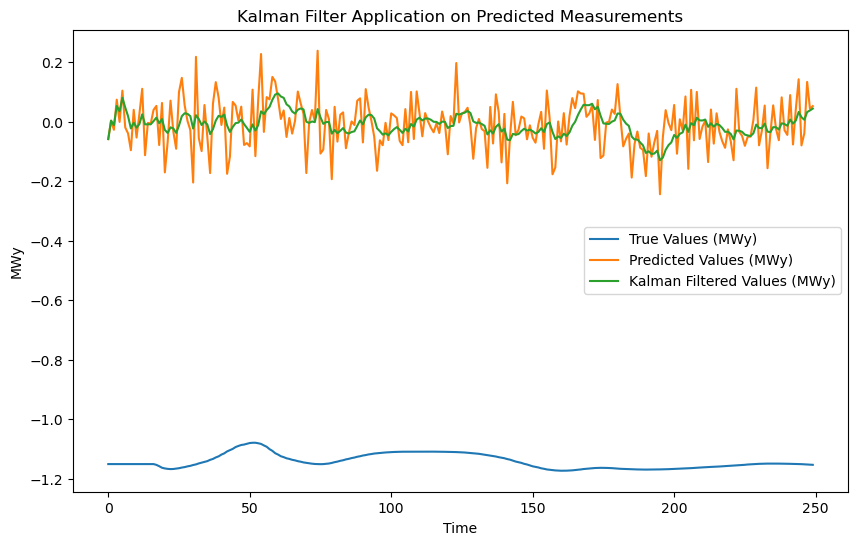

In [20]:
# Plot the results for one of the measurements (e.g., MSx)
plt.figure(figsize=(10, 6))
plt.plot(true_measurements[:250, 5], label='True Values (MWy)')
plt.plot(predicted_measurements[:250, 5], label='Predicted Values (MWy)')
plt.plot(filtered_measurements_kf[:250, 5], label='Kalman Filtered Values (MWy)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MWy')
plt.title('Kalman Filter Application on Predicted Measurements')
plt.show()


Processing EKF for each measurement:   0%|          | 0/9 [00:00<?, ?it/s]

Processing EKF for each measurement: 100%|██████████| 9/9 [02:23<00:00, 15.93s/it]


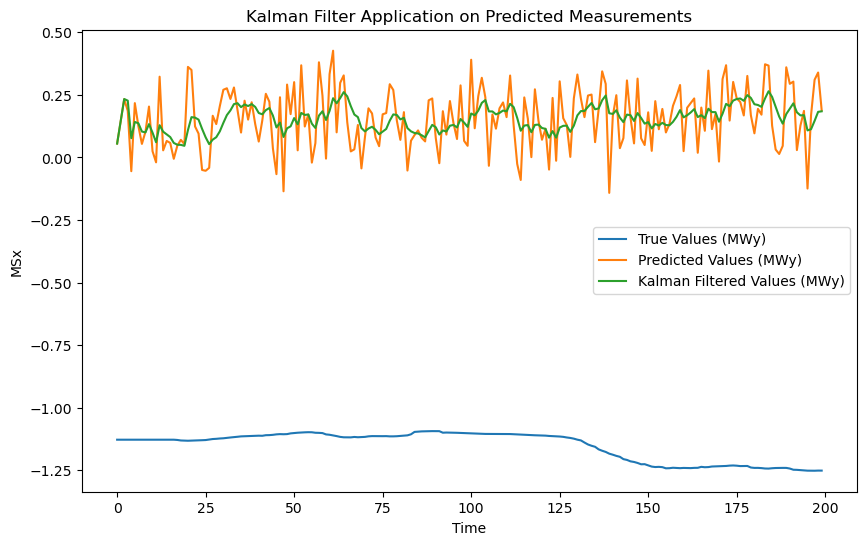

In [13]:
from filterpy.kalman import ExtendedKalmanFilter
from tqdm import tqdm

def hx(x):
    return np.array([x[0]])

def HJacobian(x):
    return np.array([[1., 0.]])

# Initialize Extended Kalman Filter for each measurement
ekf_list = []
for i in range(predicted_measurements.shape[1]):  # Number of measurements
    ekf = ExtendedKalmanFilter(dim_x=2, dim_z=1)
    ekf.x = np.array([0., 0.])  # Initial state (location and velocity)
    ekf.F = np.array([[1., 1.], [0., 1.]])  # State transition matrix
    ekf.R = measurement_noise_cov[i]  # Measurement noise covariance
    ekf.Q = process_noise_cov[i] * np.eye(2)  # Process noise covariance
    ekf_list.append(ekf)

# Apply Extended Kalman Filter to each predicted measurement
filtered_measurements_ekf = np.zeros_like(predicted_measurements)
for i in tqdm(range(predicted_measurements.shape[1]), desc="Processing EKF for each measurement"):
    ekf = ekf_list[i]
    for j in tqdm(range(predicted_measurements.shape[0]), leave=False, desc=f"Filtering measurement {i+1}"):
        ekf.predict_update(predicted_measurements[j, i], HJacobian, hx)
        filtered_measurements_ekf[j, i] = ekf.x[0]

# Plot the results for one of the measurements (e.g., MSx)
plt.figure(figsize=(10, 6))
plt.plot(true_measurements[:200, 8], label='True Values (MWy)')
plt.plot(predicted_measurements[:200, 8], label='Predicted Values (MWy)')
plt.plot(filtered_measurements_kf[:200, 8], label='Kalman Filtered Values (MWy)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MSx')
plt.title('Kalman Filter Application on Predicted Measurements')
plt.show()


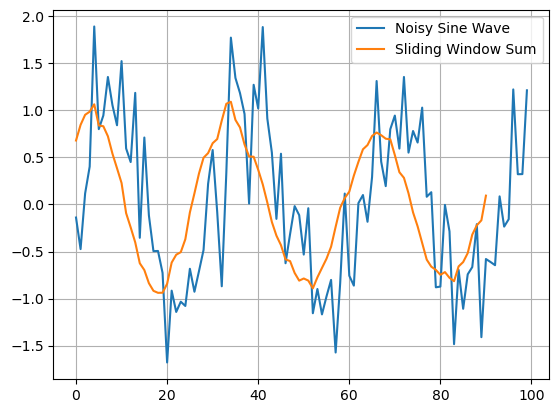

In [22]:
import numpy as np
import matplotlib.pyplot as plt 

x = np.linspace(0,20,num=100)
sin_wave = np.sin(x)

noise = np.random.normal(0, 0.5, sin_wave.shape[0])
data = sin_wave + noise

sliding_window = np.lib.stride_tricks.sliding_window_view(data,10)
sliding_window = sliding_window.mean(axis=1)


plt.plot(data,label='Noisy Sine Wave')
plt.plot(sliding_window, label='Sliding Window Sum')
plt.grid(True)
plt.legend()

plt.show()

In [6]:
sin_wave.shape



(100,)

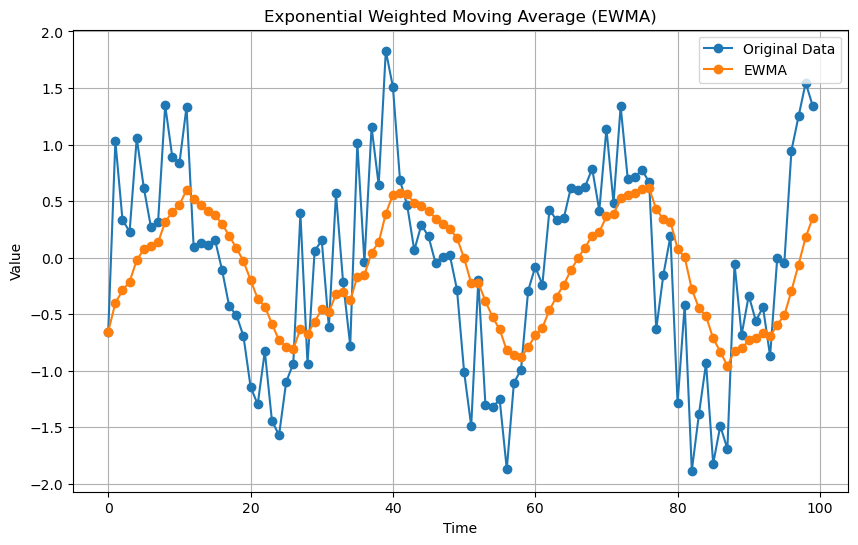

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def ewm(data, alpha):
    """
    Calculate the Exponential Weighted Moving Average (EWMA) of a data series.

    Parameters:
    data (array-like): The input data series.
    alpha (float): The smoothing factor (0 < alpha <= 1).

    Returns:
    np.ndarray: The EWMA of the data series.
    """
    data = np.asarray(data)
    ewma = np.zeros_like(data)
    ewma[0] = data[0]  # The first value is the same as the data series
    
    for t in range(1, len(data)):
        ewma[t] = alpha * data[t] + (1 - alpha) * ewma[t-1]
    
    return ewma

# Example usage
noise = np.random.normal(0, 0.5, sin_wave.shape[0])
data = sin_wave + noise
alpha = 0.15  # Smoothing factor
ewma_result = ewm(data, alpha)

# Plotting the original data and EWMA
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', marker='o')
plt.plot(ewma_result, label='EWMA', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Exponential Weighted Moving Average (EWMA)')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
! conda install -c conda-forge statsmodels -y

Channels:
 - conda-forge
 - robostack
 - defaults
 - anaconda
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/robotics20/FMG_Arm_Position/.conda

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    accelerate-0.31.0          |     pyhd8ed1ab_0         201 KB  conda-forge
    aws-c-auth-0.7.20          |       h5f1c8d9_0         103 KB  conda-forge
    aws-c-cal-0.6.12           |       h2ba76a8_0          45 KB  conda-forge
    aws-c-common-0.9.17        |       h4ab18f5_0         222 KB  conda-forge
    aws-c-compression-0.2.18   |       h36a0aea_4          19 KB  conda-forge
    aws-c-event-stream-0.4.2   |      h161de36_10          53 KB  conda-forge
    aws-c-http-0.8.1           |      h63f54a0_13         191 KB  conda-forge
    aws-c-io-0.14.8            |       h96d4d28_0 

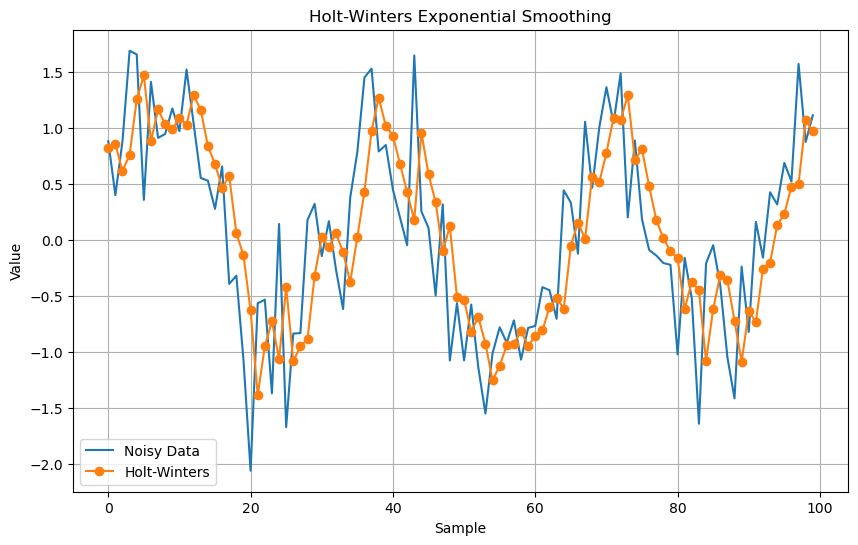

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Generate example data
np.random.seed(0)
x = np.linspace(0, 20, num=100)
sin_wave = np.sin(x)
noise = np.random.normal(0, 0.5, sin_wave.shape[0])
data = sin_wave + noise

# Apply Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(data, seasonal=None, trend='additive', seasonal_periods=12)
hw_fitted = hw_model.fit()
hw_smoothed = hw_fitted.fittedvalues

# Plot data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Noisy Data')
plt.plot(hw_smoothed, label='Holt-Winters', marker='o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Holt-Winters Exponential Smoothing')
plt.legend()
plt.grid(True)
plt.show()

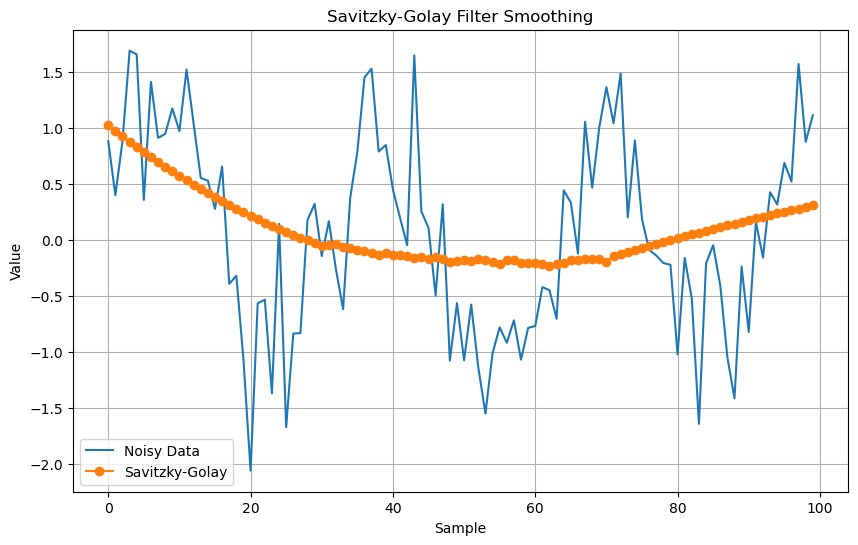

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Generate example data
np.random.seed(0)
x = np.linspace(0, 20, num=100)
sin_wave = np.sin(x)
noise = np.random.normal(0, 0.5, sin_wave.shape[0])
data = sin_wave + noise

# Apply Savitzky-Golay Filter
window_size = 55
poly_order = 2
sg_filtered = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# Plot data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Noisy Data')
plt.plot(sg_filtered, label='Savitzky-Golay', marker='o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Savitzky-Golay Filter Smoothing')
plt.legend()
plt.grid(True)
plt.show()

sensorsdf.uniqe


In [3]:
import numpy as np
from scipy.signal import savgol_filter
import time

# Sample data
np.random.seed(0)
predsToPlot = np.random.randn(1000, 32)  # Large array to test speed

# Parameters
window_size = 300
poly_order = 7
delta = 30.0

# Measure time for applying the Savitzky-Golay filter (smoothing)
start_time = time.time()
smoothed_preds = savgol_filter(predsToPlot, deriv=0, window_length=window_size, polyorder=poly_order, axis=0)
end_time = time.time()
smoothing_time = end_time - start_time

# Measure time for computing the first-order derivative
start_time = time.time()
first_order_derivative_preds = savgol_filter(predsToPlot, deriv=1, delta=delta, window_length=window_size, polyorder=poly_order, axis=0)
end_time = time.time()
derivative_time = end_time - start_time

# Measure time for adding the derivative to the smoothed data
start_time = time.time()
combined_preds = smoothed_preds + first_order_derivative_preds * 200
end_time = time.time()
combining_time = end_time - start_time

# Print the results
print(f"Time for smoothing: {smoothing_time:.6f} seconds")
print(f"Time for computing first-order derivative: {derivative_time:.6f} seconds")
print(f"Time for combining results: {combining_time:.6f} seconds")

Time for smoothing: 0.004825 seconds
Time for computing first-order derivative: 0.004500 seconds
Time for combining results: 0.000068 seconds


In [14]:
x = np.array([1,1])
y = np.array([1,1])
z = np.vstack((x,y))
z = np.vstack((z[1:],y))
z = np.vstack((z[1:],y))
z

numpy_ewma_vectorized_v2 time: 0.015745 seconds
pandas_ewm time: 0.052437 seconds


In [9]:
from types import SimpleNamespace

config =SimpleNamespace(**config)

In [28]:

locations = data[[
       'MCx','MCy', 'MCz','MSx', 'MSy', 'MSz',
       'MEx', 'MEy', 'MEz',
       'MWx', 'MWy', 'MWz'
       ]]

In [15]:

import numpy as np
import pandas as pd
import timeit

def numpy_ewma_vectorized_v2(data, window):
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n + 1))

    scale_arr = 1 / pows[:-1]
    offset = data[0] * pows[1:]
    pw0 = alpha * alpha_rev**(n - 1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out

def apply_numpy_ewma(data, window):
    batch, sequence, features = data.shape
    result = np.zeros_like(data)
    for b in range(batch):
        for f in range(features):
            result[b, :, f] = numpy_ewma_vectorized_v2(data[b, :, f], window)
    return result

def pandas_ewm(data, window):
    return data.ewm(span=window).mean().to_numpy()

def apply_pandas_ewm(data, window):
    batch, sequence, features = data.shape
    result = np.zeros_like(data)
    for b in range(batch):
        for f in range(features):
            series = pd.Series(data[b, :, f])
            result[b, :, f] = pandas_ewm(series, window)
    return result

def compare_methods(data, window):
    # Timing numpy_ewma_vectorized_v2
    numpy_time = timeit.timeit(lambda: apply_numpy_ewma(data, window), number=100)
    print(f"numpy_ewma_vectorized_v2 time: {numpy_time:.6f} seconds")

    # Timing pandas_ewm
    pandas_time = timeit.timeit(lambda: apply_pandas_ewm(data, window), number=100)
    print(f"pandas_ewm time: {pandas_time:.6f} seconds")

# Example usage
data_shape = (1, 32, 32)  # Shape of the data
window = 10               # Window size for EWMA
data = np.random.randn(*data_shape)

compare_methods(data, window)


numpy_ewma_vectorized_v2 time: 0.016065 seconds
pandas_ewm time: 0.146317 seconds


In [47]:
len(locations)

19999

In [31]:
MS = locations[['MSx', 'MSy', 'MSz']]
ME = locations[['MEx', 'MEy', 'MEz']]
MW = locations[['MWx', 'MWy', 'MWz']]

In [33]:
VStoE = ME.to_numpy()- MS.to_numpy()

In [34]:
VStoE[0]

array([-0.01941217,  0.3033426 , -0.10252228])

In [36]:
R_matrix.Get_R([0,1,0],VStoE[0])

array([[ 0.99811784, -0.06051419, -0.00994033],
       [ 0.06051419,  0.9456196 ,  0.319596  ],
       [-0.00994033, -0.319596  ,  0.94750176]])

MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



Line2D(_child0)
Line2D(_child0)
Line2D(_child0)
Line2D(_child0)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'ani.gif']' returned non-zero exit status 127.

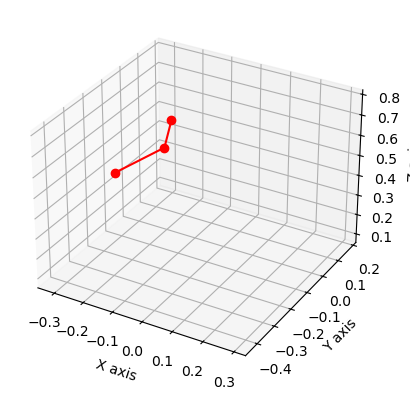

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# Assuming 'df' is your DataFrame with the columns mentioned
# Example: df = pd.read_csv('your_data_file.csv')
df = locations
# Initialize plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Adjust these limits according to your data range
ax.set_xlim([df[['MSx', 'MEx', 'MWx']].min().min(), df[['MSx', 'MEx', 'MWx']].max().max()])
ax.set_ylim([df[['MSy', 'MEy', 'MWy']].min().min(), df[['MSy', 'MEy', 'MWy']].max().max()])
ax.set_zlim([df[['MSz', 'MEz', 'MWz']].min().min(), df[['MSz', 'MEz', 'MWz']].max().max()])

# Lines to connect points
line, = ax.plot([], [], [], 'ro-')

def update(frame):
    # Extract points for the current frame
    shoulder = (df.at[frame, 'MSx'], df.at[frame, 'MSy'], df.at[frame, 'MSz'])
    elbow = (df.at[frame, 'MEx'], df.at[frame, 'MEy'], df.at[frame, 'MEz'])
    wrist = (df.at[frame, 'MWx'], df.at[frame, 'MWy'], df.at[frame, 'MWz'])

    # Update line data
    line.set_data([shoulder[0], elbow[0], wrist[0]], [shoulder[1], elbow[1], wrist[1]])
    line.set_3d_properties([shoulder[2], elbow[2], wrist[2]])
    print(line)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=range(len(df)), blit=True, repeat=True)
# ani.save('ani.gif')
plt.show()

In [13]:
from data.data_processing import DataProcessor
import yaml
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config = SimpleNamespace(**config)
data_processor = DataProcessor(config)
data_processor.load_data()
data_processor.preprocess_data()

train_loader, val_loader, test_loader = data_processor.get_data_loaders()
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"Running on the CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Running on CPU")
    return device

In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
lr = 4e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
device = set_device()

def train(epoch,lr,loader,device):
    
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(epoch):
        for inputs, targets in train_loader:

            inputs = inputs.to(device=device)
            targets = targets.to(device=device)

            optimizer.zero_grad()
            output = model(inputs.permute(0,2,1))
            loss = F.mse_loss(output, targets)
            loss.backward()
            if 1 > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            batch_idx += 1
            total_loss += loss.item()

        # if batch_idx % 100 == 0:
        #     cur_loss = total_loss / args.log_interval
        #     processed = min(i+batch_size, X_train.size(0))
        #     print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
        #         epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
        #     total_loss = 0

Running on the CUDA device: NVIDIA GeForce RTX 3060 Ti


In [20]:
train(1,lr,train_loader,device)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same